# Cluster analysis of SDMoA paintings

## Importing stuff

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle #for plotting clusters
import seaborn as sns
sns.set()
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn import metrics
from sklearn.manifold import TSNE 
from sklearn import preprocessing

In [2]:
#import matrix of average emotion scores for each painting as a pandas df
aveEmotionsMATLAB = pd.read_csv("aveEmotion.csv");
#aveEmotionsMATLAB.head(5)

In [3]:
#import all rating data
ratingData = np.empty((109, 10, 21))

for i in range(1,22):
    ratingData[:,:,i-1] = pd.read_excel("ratingData-sorted.xlsx", sheet_name=i, usecols=range(3,13))

In [4]:
#check to make sure the order of paintings is the same for all subjects
for i in range(0,21):
    print((ratingData[:,0,i] == ratingData[:,0,0]).all())
#ratingData[:,0,:]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## An exploration in normalization...

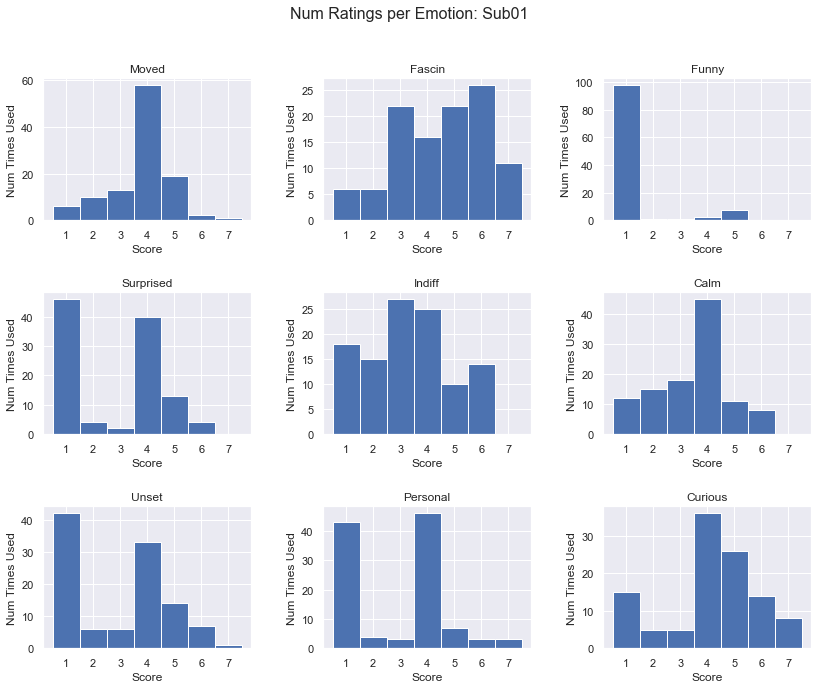

In [5]:
#histograms of scores for each emotion for sub01 (pre-normalizing)

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

#plt.setp(axes, xticks=[1,2,3,4,5,6,7]) 
emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub01", size=16)

dim=331
for i in range(1,10):
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                      xticks=np.arange(1,8,1)
                     )
    plt.hist(ratingData[:,i,0], range=[1, 8], bins=7, align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


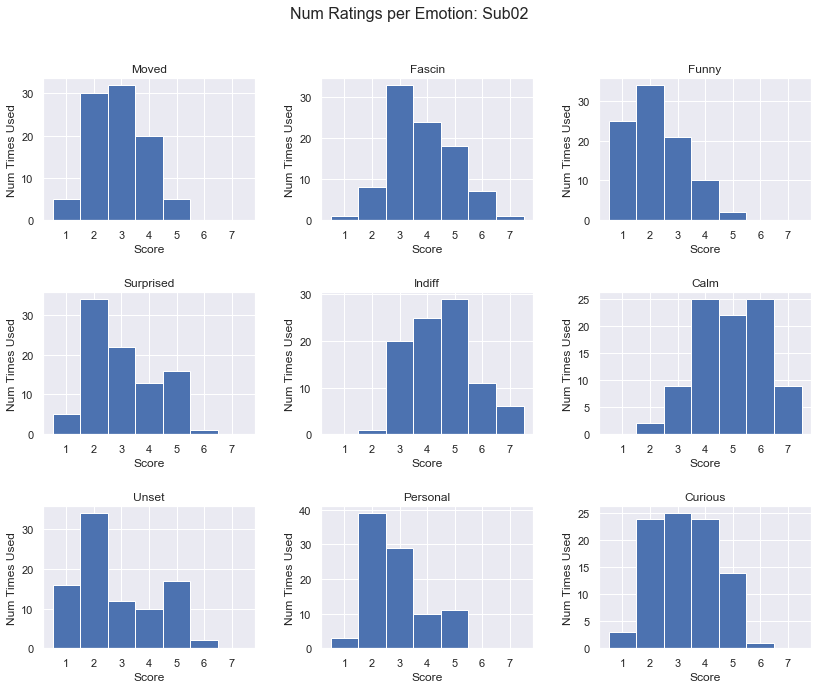

In [6]:
#histogram of average Moved score for sub02

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub02", size=16)

dim=331
for i in range(1,10):
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                      xticks=np.arange(1,8,1)
                     )
    plt.hist(ratingData[:,i,1], range=[1, 8], bins=7, align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

Different emotions have really different distributions, even within a subject, so I definitely agree that we should standardize per subject & emotion rather than just subject.

In [7]:
#standardize data per person per emotion (find mean, find sd, substract mean and divide by sd)
standardRating = np.copy(ratingData)

for i in range(0,20): #per subject
    for j in range(1,10): #per emotion
        # standardize across all paintings for this subject/emotion
        standardRating[:,j,i] = preprocessing.scale(ratingData[:,j,i])

In [8]:
#just making sure this^ did something
print(ratingData[0,:,0])
print(standardRating[0,:,0])

[1.001e+03 4.000e+00 5.000e+00 1.000e+00 1.000e+00 4.000e+00 5.000e+00
 1.000e+00 5.000e+00 2.000e+00]
[ 1.00100000e+03  2.04383195e-01  3.00000000e-01 -3.20277304e-01
 -1.08274325e+00  4.28626422e-01  1.12656998e+00 -1.10861485e+00
  1.20744681e+00 -1.28173825e+00]


I also tried computing this without using the preprocessing module, just to double check it was doing the same thing and indeed it was! But there was an error: RuntimeWarning: invalid value encountered in double_scalars so I'm using the preprocessing. This was the other version:  

In [9]:
#standardRatingByHand = np.copy(ratingData)

#for i in range(0,20):
    #for j in range(0,9):
        #mean = np.nanmean(standardRatingByHand[:,j,i])
        #sd = np.nanstd(standardRatingByHand[:,j,i])
        #for k in range(0,109):
            #standardRatingByHand[k,j,i] = (standardRatingByHand[k,j,i]-mean)/sd

# np.allclose(standardRating,standardRatingByHand, equal_nan=True) --> this outputs True

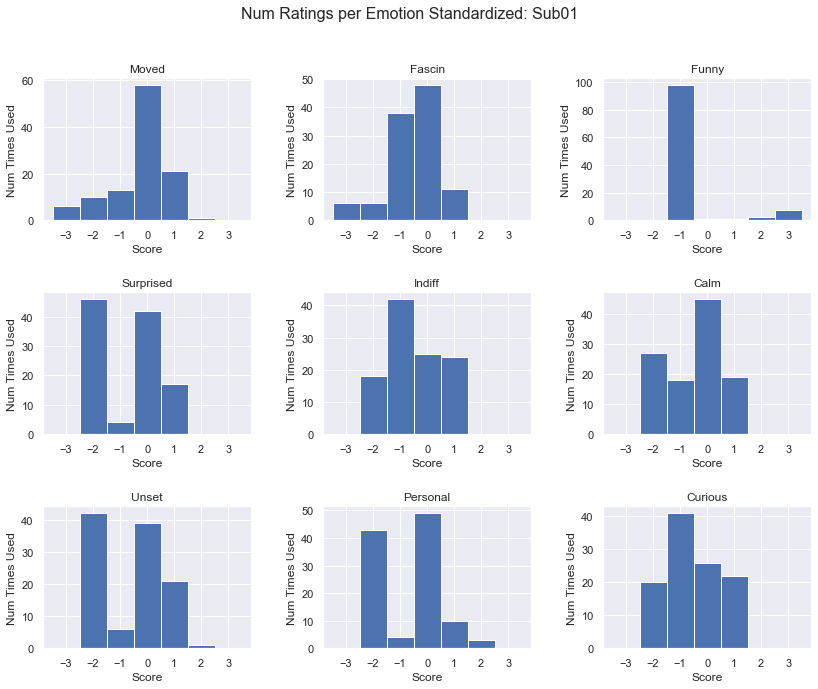

In [10]:
#histogram of average scores for each emotin for sub01 - post-standarizing
fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion Standardized: Sub01", size=16)

dim=331
for i in range(1,10):
    #xmin, xmax = min(standardRating[:,i,0]), max(standardRating[:,i,0])
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                    xticks=np.arange(-3, 4, 1)
                     )
    plt.hist(standardRating[:,i,0], bins=7, range=[-3.0, 4.0], align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

# for i in range(0,9):
#     plt.subplot(dim+i)
#     plt.hist(standardRating[:,i+1,0], bins=7)
#     plt.title(emotionList[i])
    
# plt.tight_layout()
# fig.subplots_adjust(top=0.88)



### Looks like this didn't change the distribution at all? Might be a visualization issue on my end though. I was having trouble with this graphs >:(

Robert: I don't think we would expect this to change the distribution, if we are still using the same number of bins (7) with equal spacing. The scores have changed though, are now seen in standard units. (0 is mean, +/- vals are multiples of std. dev.)

### : )

In [11]:
#This is what I did before - can ignore
#standardRating = ratingData

#for i in range(0,20):
    #standardRating[:,:,i] = preprocessing.scale(ratingData[:,:,i], axis=1)
    
#print(standardRating[:,:,20])

Recreating the matrix of averages

In [12]:
# means of each painting's emotion
aveEmotionsCopy = standardRating.copy()
aveEmotions = aveEmotionsCopy[:,:,1]

for i in range(0,109):
    for j in range(1,10):
        aveEmotions[i,j] = np.nanmean(aveEmotionsCopy[i,j,:])

In [13]:
# turing aveEmotions into a df
aECols = ['ID','Moved','Fascinated','Funny','Surprised','Indifferent','Calm','Unsettling','Personal','Curious']
aveEmotions = pd.DataFrame(data=aveEmotions, columns=aECols)
aveEmotions.head(10)

,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious
0,1001.0,0.055470,0.539793,-0.064899,0.359758,0.021301,0.302132,-0.053292,0.528519,0.487520
1,1002.0,-0.169808,-0.102406,0.935254,0.296957,0.517164,0.760554,-0.330602,0.151187,-0.121077
2,1003.0,0.110177,0.052632,-0.110637,0.125753,0.293006,0.560921,-0.119360,0.530289,0.076214
3,1004.0,0.676105,0.365665,-0.356315,-0.138310,-0.299066,1.280370,-0.594691,0.445455,0.378468
4,1005.0,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,0.327951,-0.358358,0.388488
5,1006.0,-0.605781,-0.398667,-0.007742,-0.161781,0.791667,-0.005937,-0.094401,-0.546196,-0.250616
6,1007.0,0.326431,0.375793,-0.261574,0.394683,-0.190735,0.909559,-0.431250,0.643413,0.246484
7,1008.0,-0.055526,0.144564,-0.100754,0.103671,0.753893,0.066126,0.106312,-0.276569,-0.085208
8,1009.0,0.297149,0.608318,0.161487,0.302879,-0.405464,0.603738,0.293114,0.504394,0.673587
9,1010.0,0.397693,0.754296,0.050886,0.199996,-0.235692,0.180377,-0.397177,0.676866,0.492395


### Variability

In [14]:
# create matrix of variance scores for each painting
# not using this for anything - just wanted to see what it looked like. Overall, pretty uniform, with a few exceptions.
varsPerPainting = np.zeros(109)

for i in range(0,109):
    varsPerPainting[i] = np.nanvar(standardRating[i,1:10,:])
    
varsPerPainting = pd.DataFrame(data=varsPerPainting, columns=['Universal Var'])
varsPerPainting.head(10)

,Universal Var
0,1.702009
1,1.710756
2,1.305685
3,1.472761
4,1.952177
5,1.969290
6,1.288078
7,1.470936
8,1.025884
9,1.237239


In [15]:
#create matrix of variance scores for each emotional dimension per painting
varsPerEmotionCopy = standardRating.copy()
varsPerEmotion = varsPerEmotionCopy[:,:,1]

for i in range(0,109):
    for j in range(1,10):
        varsPerEmotion[i,j] = np.nanvar(varsPerEmotionCopy[i,j,:])
        
varCols = ['ID','Moved Var','Fascin Var','Funny Var','Surp Var','Indiff Var','Unset Var','Calm Var','Personal Var','Curious Var']
varsPerEmotion = pd.DataFrame(data=varsPerEmotion, columns=varCols)
#adding the total variance because I can
varsPerEmotion = varsPerEmotion.join(varsPerPainting)
varsPerEmotion.head(10)

,ID,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
0,1001.0,1.469095,2.705098,0.434023,2.345384,1.123710,2.607894,0.545858,1.173602,2.399997,1.702009
1,1002.0,1.089603,1.207971,1.079433,1.544642,2.720036,3.344687,0.935159,0.987593,0.909742,1.710756
2,1003.0,0.757121,0.776568,0.366995,0.688864,3.120077,3.108315,1.008598,0.502257,0.934030,1.305685
3,1004.0,1.068954,1.856642,0.471329,0.678363,1.408542,1.739413,0.521262,1.146397,1.551546,1.472761
4,1005.0,0.703871,2.770416,1.192220,1.865725,1.055493,2.525433,0.710057,0.928565,2.474610,1.952177
5,1006.0,1.054226,2.646811,0.652478,2.344780,1.917509,3.072568,1.172885,0.838736,2.656543,1.969290
6,1007.0,0.813634,1.580131,0.420325,1.536955,0.685847,2.949345,0.539474,0.919258,0.586403,1.288078
7,1008.0,0.812552,1.147625,0.604931,1.370797,3.237464,1.124191,1.813613,1.167296,1.295181,1.470936
8,1009.0,0.991774,1.128164,0.371438,0.781722,0.405380,1.024036,0.854010,0.638591,2.168337,1.025884
9,1010.0,0.751950,1.732036,0.587934,0.674827,0.598062,2.533620,0.393952,0.587730,2.058105,1.237239


In [16]:
#create aveEmotions copy without ID column to be used for clustering

X = aveEmotions.drop(['ID'],axis=1)
X = X.to_numpy()

#X = np.delete(aveEmotions, 0, axis=1) # <-- can't remember what this does but it was there last time so.....
#print(X[:10]) # first ten rows

### Dimensional Reduction (t-SNE)

So we can plot our 9-dim data in 2-d.

Sydney: I set perplexity to 20, which is kind of an arbitrary number, since I think that's around the average number of paintings in each gallery....

Robert: I played around and settled on 30. but you're right the choice is arbitrary.

See Notes on t-SNE: [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/)

In [17]:
# choice of perplexity is subjective, until you see a good layout/separation
# tsne = TSNE(n_components=2, perplexity = 20, random_state = 0) 

tsne = TSNE(n_components=2, perplexity = 30, random_state = 0) 

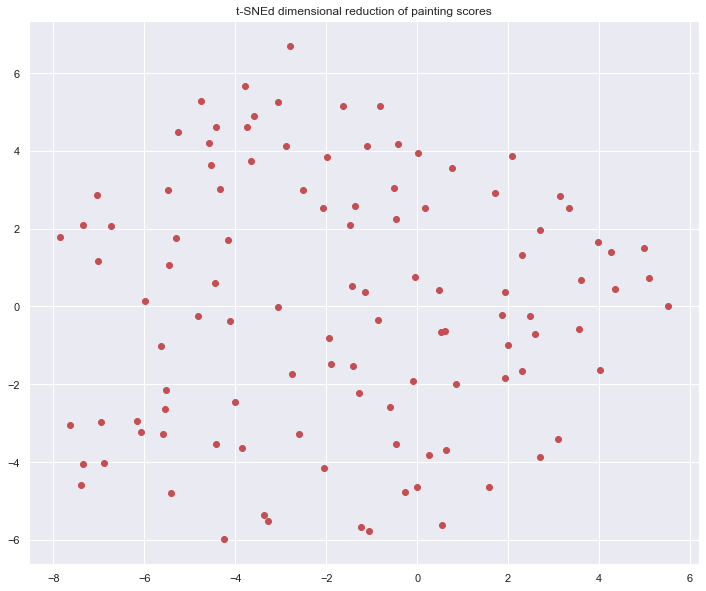

In [18]:
# tSNE performed on aveEmotions data

X_tsned = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
tsned = plt.scatter(X_tsned[:,0],X_tsned[:,1],c='r')
plt.title('t-SNEd dimensional reduction of painting scores')
plt.show()

__NOTE__: UMAP is another dimensional reduction technique we could explore. 

- https://umap-learn.readthedocs.io/en/latest/
- https://arxiv.org/abs/1802.03426

Would have to look into whether it is appropriate for our use case.

## Clustering time!

### shared clustering code and helper functions

In [19]:
af = AffinityPropagation()

ratings = np.array([1,2,3,4,5,6,7,8,9])

# function to get a table of the amount of paintings in each cluster
#whichCluster is a string
def amountInCluster(whichCluster,numClusters):
    clusterList = list(range(0,numClusters,1))
    clusterAmount = list(range(0,numClusters,1))

    for i in range(0,numClusters):
        clusterAmount[i] = aveEmotions[whichCluster][(aveEmotions[whichCluster] == i)].count()
    
    clusterDict = {'Cluster': clusterList, 'numItems': clusterAmount}
    clusterAmounts = pd.DataFrame.from_dict(clusterDict)
    
    return clusterAmounts

# function to get col means for each cluster

#whichCluster is a str
def addColAverage(whichCluster,clusterNum):  
    cluster = aveEmotions[(aveEmotions[whichCluster] == clusterNum)] #grabs paintings in a cluster
    means = cluster.mean() #col means
#     means = means.drop(labels = ["ID","ClusterAfter","ClusterBefore","ClusterKMeans"]) #drop Cluster labels
    means = means.drop(labels = ["ID","ClusterBefore"]) #drop Cluster labels
    means = means.to_numpy() #converts series to numpy array
    
    return means

### Clustering After t-SNE (this is what I originally had, and where the graphs I sent came from)

Robert: I'm going to comment this out, because we shouldn't use it!

In [20]:
# #Cluster! That! Data!
# clustering = af.fit(X_tsned) 

# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

In [21]:
# # 8 clusters this time!

# print(cluster_centers_indices)
# print(labels)
# print(n_clusters_)

In [22]:
# #adding labels to a new aveEmotions df
# aveEmotions['ClusterAfter'] = list(labels)
# aveEmotions['ClusterBefore'] = np.nan 
# aveEmotions['ClusterKMeans'] = np.nan #this is empty for now so certain functions Work
# aveEmotions.head(5)

In [23]:
# # from sklearn's demo of affinity propogation

# plt.close('all')
# plt.figure(figsize=(8, 6))
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X_tsned[cluster_centers_indices[k]]
#     plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, 
#              markeredgecolor='k', markersize=14)
#     for x in X_tsned[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [24]:
# # function to get a table of the amount of paintings in each cluster

# #whichCluster is a string
# def amountInCluster(whichCluster,numClusters):
#     clusterList = list(range(0,numClusters,1))
#     clusterAmount = list(range(0,numClusters,1))

#     for i in range(0,numClusters):
#         clusterAmount[i] = aveEmotions[whichCluster][(aveEmotions[whichCluster] == i)].count()
    
#     clusterDict = {'Cluster': clusterList, 'numItems': clusterAmount}
#     clusterAmounts = pd.DataFrame.from_dict(clusterDict)
    
#     return clusterAmounts

In [25]:
# clusterCountAfter = amountInCluster('ClusterAfter',n_clusters_)
# clusterCountAfter

In [26]:
# # function to get col means for each cluster

# #whichCluster is a str
# def addColAverage(whichCluster,clusterNum):  
#     cluster = aveEmotions[(aveEmotions[whichCluster] == clusterNum)] #grabs paintings in a cluster
#     means = cluster.mean() #col means
#     means = means.drop(labels = ["ID","ClusterAfter","ClusterBefore","ClusterKMeans"]) #drop Cluster labels
#     means = means.to_numpy() #converts series to numpy array
    
#     return means

In [27]:
# #this will be the x vals for plotting
# ratings = np.array([1,2,3,4,5,6,7,8,9])

# #this checks to make sure addColAverage works
# #print(type(addColAverage("ClusterAfter",0)))
# print(addColAverage("ClusterAfter",0))

In [28]:
# # plot the emotion averages of each cluster

# fig, axes= plt.subplots(nrows=2, ncols=4, sharey = True, figsize=(16,6))

# plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
#                                                         #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
# k = 0
# for i in range(0,2):
#     for j in range(0,4):
#         axes[i,j].plot(ratings, addColAverage("ClusterAfter",k))
#         axes[i,j].set_title('Cluster {number}'.format(number = k))
#         k = k+1

# plt.tight_layout()

# plt.show()

### Clustering Before t-SNE

Robert: This is what we want!

In [29]:
#fitting X (9-dim) instead of transformed X_tsned
clustering2 = af.fit(X) 
                             
cluster_centers_indices2 = af.cluster_centers_indices_
labels2 = af.labels_
n_clusters_2 = len(cluster_centers_indices2)

aveEmotions['ClusterBefore'] = labels2

In [30]:
aveEmotions.head(5)

,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious,ClusterBefore
0,1001.0,0.055470,0.539793,-0.064899,0.359758,0.021301,0.302132,-0.053292,0.528519,0.487520,7
1,1002.0,-0.169808,-0.102406,0.935254,0.296957,0.517164,0.760554,-0.330602,0.151187,-0.121077,1
2,1003.0,0.110177,0.052632,-0.110637,0.125753,0.293006,0.560921,-0.119360,0.530289,0.076214,7
3,1004.0,0.676105,0.365665,-0.356315,-0.138310,-0.299066,1.280370,-0.594691,0.445455,0.378468,7
4,1005.0,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,0.327951,-0.358358,0.388488,8


In [31]:
#11 clusters now

print(cluster_centers_indices2)
print(labels2)
print(n_clusters_2)

[ 41  43  50  53  57  58  59  72  91 106 107]
[ 7  1  7  7  8  2  7  9  7  7  6  6  8  3  3 10  8  9  7  3  3  2 10  1
  3  9 10  8  9  8  1  1  3  3  1 10  9  3  1  3  1  0  1  1 10  2  9  1
  2  2  2  0  9  3  2  9  1  4  5  6  9  6  6  2  7  2  1  7 10  9  1  7
  7  4  2 10  0  7  4  4  1  7  6  9  9 10  7  0  3  6  9  8  6  7  7  7
  9  4  7  6  1  6  7  7  6  6  9 10  4]
11


I'm not sure I'm doing what you want me to do here...I'm trying to use the transformed data (which should be the same as it was above) to plot the clusters you get when considering all 9 dimensions. The cluster look a little weird, though.

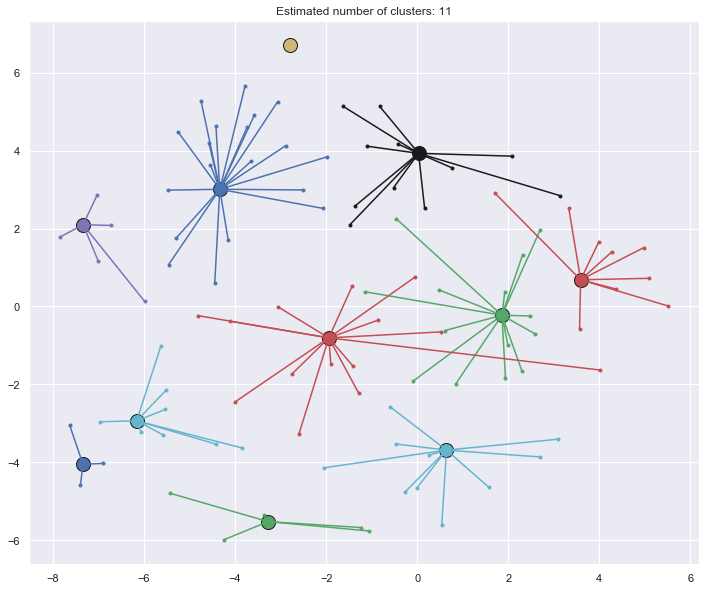

In [32]:
# using X_tsned (transformed data) instead of X

plt.close('all')
plt.figure(figsize=(12, 10))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_2), colors):
    class_members = labels2 == k
    cluster_center = X_tsned[cluster_centers_indices2[k]]
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X_tsned[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

plt.title('Estimated number of clusters: %d' % n_clusters_2)
plt.show()

#fig.savefig('cluster-graph.png') <--this......does not work :( i can't figure out where to place "fig" w/o ruining the graph

In [33]:
clusterCountBefore = amountInCluster('ClusterBefore',n_clusters_2)
clusterCountBefore.numItems[0]

4

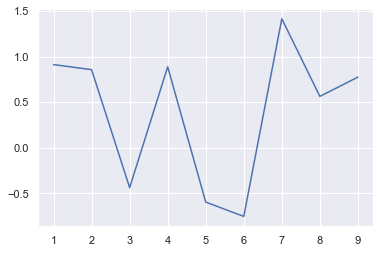

In [34]:
plt.plot(ratings, np.array(addColAverage("ClusterBefore",0)))
# print(type(addColAverage("ClusterBefore",0)))

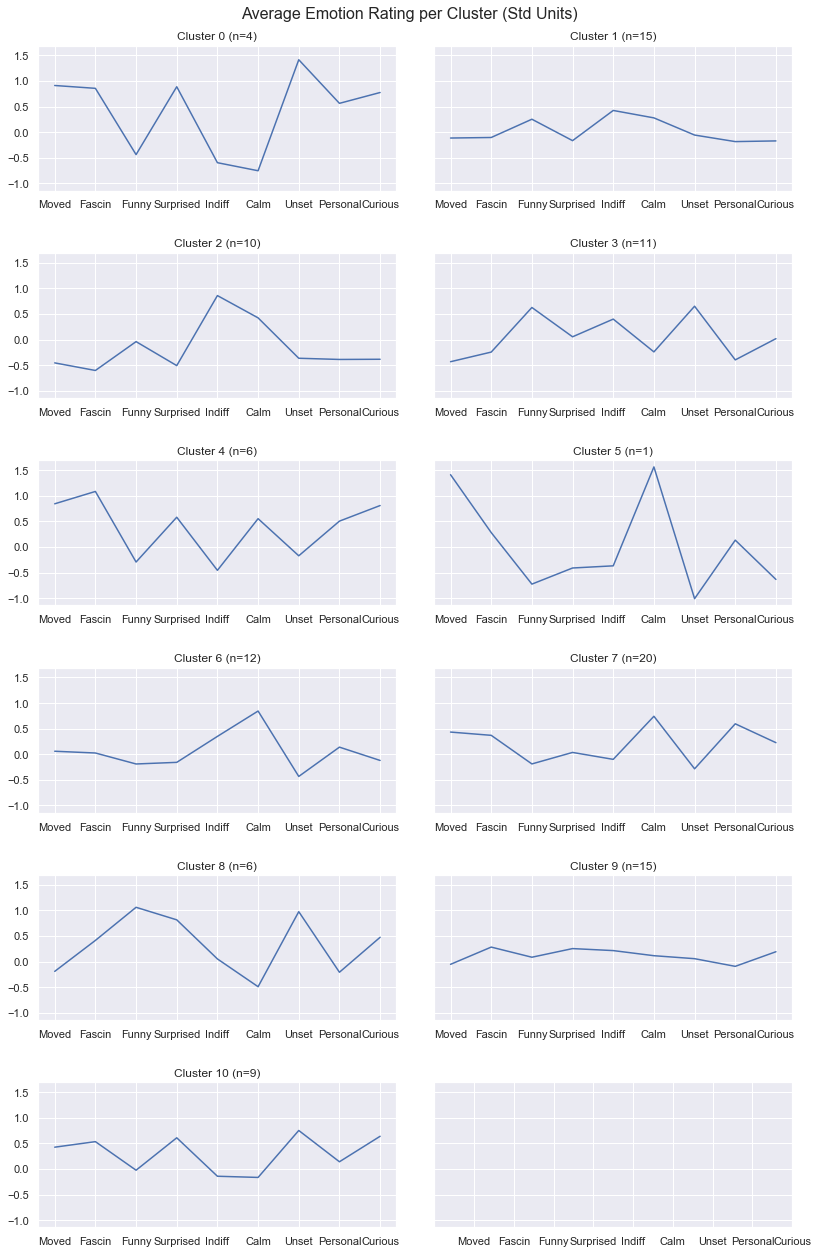

In [35]:
# plot the emotion averages of each cluster

fig, axes= plt.subplots(nrows=6, ncols=2, sharey = True, figsize=(12,18))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Average Emotion Rating per Cluster (Std Units)", size=16)

k = 0
for i in range(0,6):
    for j in range(0,2):
        if k<n_clusters_2:
            axes[i,j].plot(ratings, addColAverage("ClusterBefore",k))
            axes[i,j].set_title('Cluster {number} (n={amount})'.format(number = k, amount=clusterCountBefore.numItems[k]))
            k = k+1

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.95)

plt.show()

fig.savefig('cluster-averages-linegraph.png')

I'm putting all the stuff I had here about combining clusters in another document - I don't think we'll need it anymore haha.

### Clustering With KMeans (Before t-SNE)

Robert: not used here

In [36]:
# #fitting X (9-dim) instead of transformed X_tsned
# n_clusters_km = 13
# km = KMeans(n_clusters=n_clusters_km)

# clusteringkm = km.fit(X) 
                             
# labelskm = km.labels_

# aveEmotions['ClusterKMeans'] = labelskm

In [37]:
# # using X_tsned (transformed data) instead of X

# plt.close('all')
# plt.figure(figsize=(10, 8))
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_km), colors):
#     class_members = labelskm == k
#     plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')

# plt.title('Estimated number of clusters: %d' % n_clusters_km)
# plt.show()

# Combining everything together!

In [38]:
## importing all rating data to recover painting names/galleries

names = pd.read_excel("ratingData-sorted.xlsx", sheet_name=1, usecols=range(0,4))
names.rename(columns = {"Unique ID":"ID"}, inplace = True)
names

,Title,Artist,Gallery,ID
0,Untitled,George Copeland Ault,1,1001
1,Pool in the Mountains,Milton Avery,1,1002
2,Simone in a Blue Bonnet (No. 1),Mary Cassatt,1,1003
3,"The Chase Homestead, Shinnecock, Long Island",William Merritt Chase,1,1004
4,Composition with Boats,Stuart Davis,1,1005
...,...,...,...,...
104,Maria at La Granja,Sorolla y Bastida,200,20002
105,Seine in Parin,Dufy,200,20003
106,Tutzing,Munter,200,20004
107,Mother and Child,Van Gogh,200,20005


In [39]:
#everything at once
labeledRatings = names.merge(aveEmotions, on=['ID'])
# labeledRatings = labeledRatings.drop(['ClusterAfter', 'ClusterKMeans'], axis=1)
labeledRatings = labeledRatings.merge(varsPerEmotion, on=['ID'])
labeledRatings.head()


labeledRatings.to_excel('labeledRatings.xlsx')

In [40]:
labeledRatings[(labeledRatings['ClusterBefore'] == 8)]

,Title,Artist,Gallery,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,...,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
4,Composition with Boats,Stuart Davis,1,1005,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,...,0.703871,2.770416,1.192220,1.865725,1.055493,2.525433,0.710057,0.928565,2.474610,1.952177
12,Still-life Synchromy with Nude in Yellow,Morgan Russell,1,1013,-0.159442,0.504800,0.719936,1.106089,0.158917,-0.279939,...,1.570895,3.305835,1.653232,3.275903,0.938572,1.794606,1.000084,1.108713,3.351918,2.229526
16,"Beach, Beauville",Guy Pène du Bois,1,1017,-0.337914,0.277624,1.490102,0.479166,0.333759,-0.000683,...,0.621786,1.613639,5.186650,1.280066,1.567311,2.248992,0.974394,0.843923,1.368550,1.988951
27,The Crucifixion,Martín Bernat,16,1604,0.356850,0.494097,0.188157,0.548391,-0.140123,-0.998613,...,1.360744,3.234346,2.595595,2.474896,0.644215,0.929877,2.459275,0.913268,3.217900,2.374906
29,The Arrest of Christ,Hieronymus Bosch,16,1606,0.081167,0.499141,1.549602,1.196059,-0.641634,-1.012729,...,1.382011,3.095759,3.120371,2.435656,0.381721,1.314295,2.024019,0.939119,2.910653,2.785893
91,Woman Seated,Hans Hofmann,3,3009,-0.264063,0.485777,0.933086,0.938726,0.095991,-0.574195,...,1.159402,2.062629,1.312103,1.847799,0.732009,1.553999,0.865769,0.874540,1.774399,1.654872


In [41]:
#given a cluster, creates a list of the number of paintings in each gallery
galleryList = list(["1","2","3","100","16","19","200"])
galleries = [1,2,3,100,16,19,200]

def numInGallery(clusterNum):

    numIn = np.zeros(7)
    
    sampleCluster = labeledRatings.ClusterBefore == clusterNum
    
    for i in range(0,7):
        sampleGal = labeledRatings.Gallery==galleries[i]
        numIn[i]= len(labeledRatings[sampleCluster & sampleGal])
    
    numIn = list(numIn)
    
    return numIn

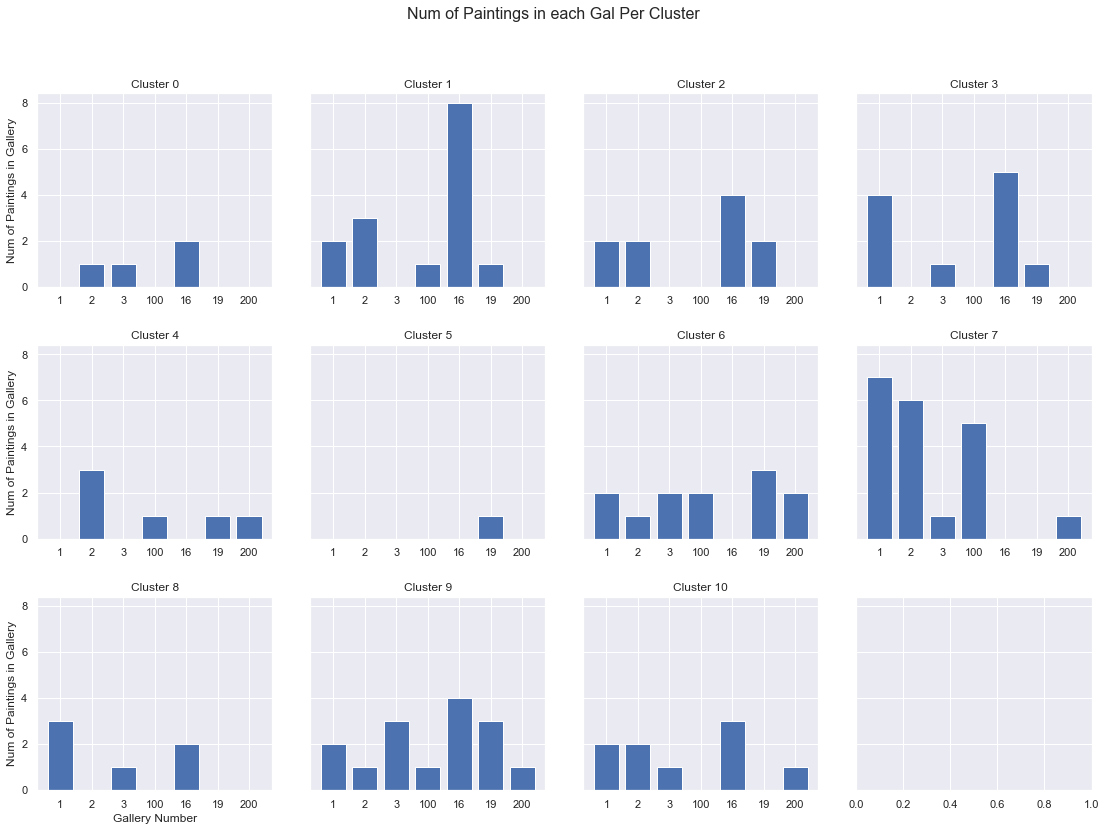

In [42]:
# for each cluster, plot num paintings in each gallery 

fig, axes= plt.subplots(nrows=3, ncols=4, sharey = True, figsize=(16,12))  #[1,2,3,100,16,19,200]

#plt.setp(axes, xticks=[1,2,3,3,4,5,6,7]) #, yticks=[1,2,3,4,5,6,7,8]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
                                                        #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
fig.suptitle("Num of Paintings in each Gal Per Cluster", size=16)
numGals = [1,2,3,4,5,6,7]

k = 0
for i in range(0,3):
    for j in range(0,4):
        if k<n_clusters_2:
            axes[i,j].bar(numGals, numInGallery(k))
            axes[i,j].set_title('Cluster {number}'.format(number = k))
            axes[i,j].set_xticks([1,2,3,4,5,6,7])
            axes[i,j].set_xticklabels(galleryList)
            if j==0:
                axes[i,j].set_ylabel("Num of Paintings in Gallery")
                if i==2:
                    axes[i,j].set_xlabel("Gallery Number")
            k = k+1

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)
fig.savefig('num-paintings-in-gal.png')

plt.show()

In [43]:
# Highest Scores

#most moving
#print(labeledRatings.iloc[(labeledRatings['Moved'].idxmax())])

#most fascinating
#print(labeledRatings.iloc[(labeledRatings['Fascinated'].idxmax())])

#most funny
#print(labeledRatings.iloc[(labeledRatings['Funny'].idxmax())])

#most surprised
#print(labeledRatings.iloc[(labeledRatings['Surprised'].idxmax())])

#most indifferent
#print(labeledRatings.iloc[(labeledRatings['Indifferent'].idxmax())])

#most calm
#print(labeledRatings.iloc[(labeledRatings['Calm'].idxmax())])

#most unsettling
#print(labeledRatings.iloc[(labeledRatings['Unsettling'].idxmax())])

#most personal
#print(labeledRatings.iloc[(labeledRatings['Personal'].idxmax())])

#most curious
#print(labeledRatings.iloc[(labeledRatings['Curious'].idxmax())])

## Choosing Paintings

# 1) REVISED: by Arousal & Valence
Arousal scores being the sum of a painting's ratings for Moved, Fascinated, Surprised, and Funny. Top 40 highest are in the High Arousal category, lowest 40 is the Low Arousal

In [44]:
#create a column of arousal scores
arousalMatrix = labeledRatings.copy()
arousalMatrix = arousalMatrix.iloc[:,0:13]

arousalMatrix['arousal'] = arousalMatrix.Moved+arousalMatrix.Fascinated+arousalMatrix.Funny+arousalMatrix.Surprised
    #arousalMatrix.Calm+arousalMatrix.Unsettling
arousalMatrix = arousalMatrix.sort_values(by=['arousal'], ascending=False)

arousalMatrix.head(n=5)

,Title,Artist,Gallery,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious,arousal
79,Sunset View of the Gateway of Venice,Thomas Moran,2,2016,1.212976,1.609849,-0.171673,1.005395,-0.546367,0.644758,-0.058714,0.568578,1.028536,3.656547
29,The Arrest of Christ,Hieronymus Bosch,16,1606,0.081167,0.499141,1.549602,1.196059,-0.641634,-1.012729,1.723363,-0.324896,0.614187,3.325969
85,After Many Days,Thomas Hart Benton,3,3003,0.712951,0.979132,0.026048,0.992900,-0.386934,-0.387419,0.749403,0.487055,0.788618,2.711032
57,Notre Dame,Maximilien Luce,19,1906,0.973386,1.102660,-0.278994,0.755614,-0.591570,0.507965,-0.262706,0.670664,0.581072,2.552665
41,The Penitent Magdalene,Giulio Cesare Procaccini,16,1618,0.981587,0.748148,-0.437467,1.079746,-0.549352,-0.870230,1.405736,0.424585,0.811505,2.372012


In [45]:
highArousal = arousalMatrix.head(n=40)
lowArousal = arousalMatrix.tail(n=40)

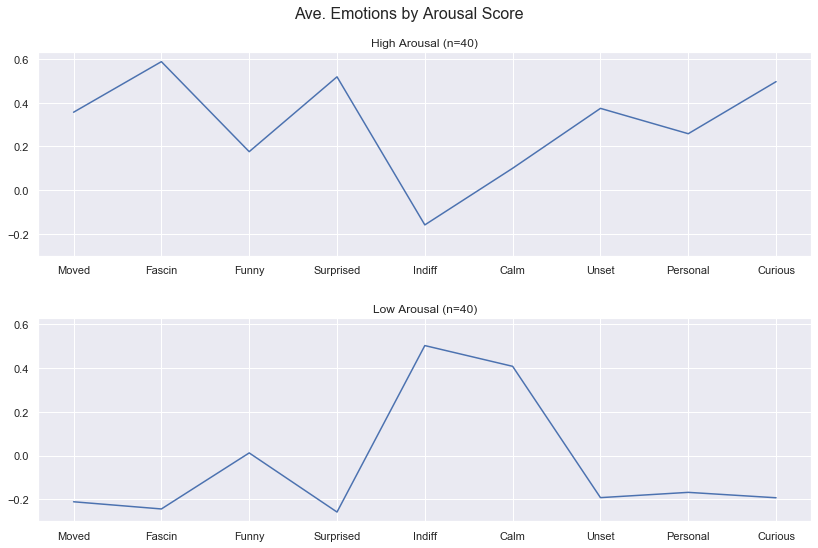

In [46]:
#line graphs of arousals
fig, axes= plt.subplots(nrows=2, ncols=1, sharey = True, figsize=(12,8))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Ave. Emotions by Arousal Score", size=16)

highArousalMeans = np.mean(highArousal.iloc[:,4:13])
lowArousalMeans = np.mean(lowArousal.iloc[:,4:13])

axes[0].plot(ratings, highArousalMeans)
axes[0].set_title('High Arousal (n=40)')

axes[1].plot(ratings, lowArousalMeans)
axes[1].set_title('Low Arousal (n=40)')

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)

plt.show()

fig.savefig('ave-emotions-by-arousal.png')

## Now, trying to separate by positive vs. negative valence
I tried a few different ways for this. First is the way we talked about: sorting by "Unsettling" for High Arousal and "Indifference" for low arousal.

In [47]:
hA_negative = highArousal.sort_values(by=['Unsettling']).tail(n=20)
hA_positive = highArousal.sort_values(by=['Unsettling']).head(n=20)

lA_negative = lowArousal.sort_values(by=['Indifferent']).tail(n=20)
lA_positive = lowArousal.sort_values(by=['Indifferent']).head(n=20)

### To quickly see if there was a difference between the two groups, I summed the categories of interest.

In [48]:
print('Fascinated Sums:')
print('High Arousal Positive: ' + str(hA_positive['Fascinated'].sum()))
print('High Arousal Negative: ' + str(hA_negative['Fascinated'].sum()))
print('')
print('Unsettling Sums:')
print('High Arousal Positive: ' + str(hA_positive['Unsettling'].sum()))
print('High Arousal Negative: ' + str(hA_negative['Unsettling'].sum()))
print('')
print('')
#lA_negative = lowArousal.sort_values(by=['Calm']).tail(n=20)
#lA_positive = lowArousal.sort_values(by=['Calm']).head(n=20)
print('')
print('Indifferent Sums:')
print('Low Arousal Positive: ' + str(lA_positive['Indifferent'].sum()))
print('Low Arousal Negative: ' + str(lA_negative['Indifferent'].sum()))
print('')
print('Calm Sums:')
print('Low Arousal Positive: ' + str(lA_positive['Calm'].sum()))
print('Low Arousal Negative: ' + str(lA_negative['Calm'].sum()))

Fascinated Sums:
High Arousal Positive: 12.847327802714108
High Arousal Negative: 10.630810192181057

Unsettling Sums:
High Arousal Positive: -3.4933683432481097
High Arousal Negative: 18.44443649552403



Indifferent Sums:
Low Arousal Positive: 5.028248607563359
Low Arousal Negative: 15.052961306372184

Calm Sums:
Low Arousal Positive: 9.740227301292332
Low Arousal Negative: 6.5521713368835774


### It seems that the categories that weren't the measure we split on weren't that different between groups (ie, the positive group and negative groups for high arousal have similar sums of Fascination scores, even though they have big differences in the Unsettling sumss, which is what the groups were divided on.) The same thing happened when sorted on Calm instead of Indifferent, but in the reverse.

### This was reflected in the plots, too. 

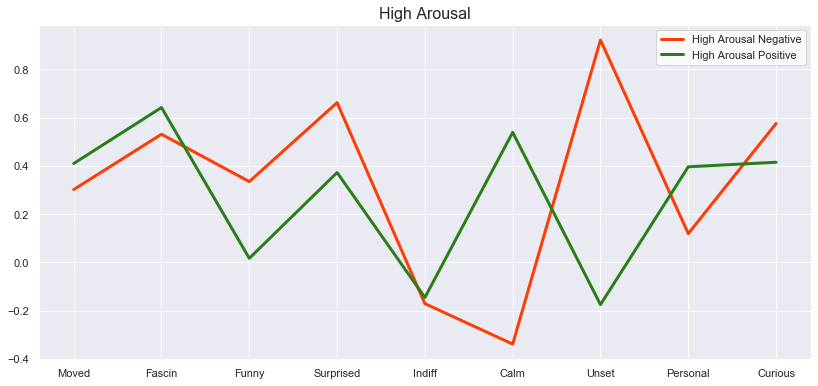

In [49]:
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
plt.title("High Arousal", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

ax.plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
ax.plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:tree green', linewidth=3)

plt.legend(facecolor='w')

plt.tight_layout(pad=3.0)

plt.show()

fig.savefig('high-arousal.png')

### Unsettling is nicely separated, but Moved & Fascinating tracked pretty closely together

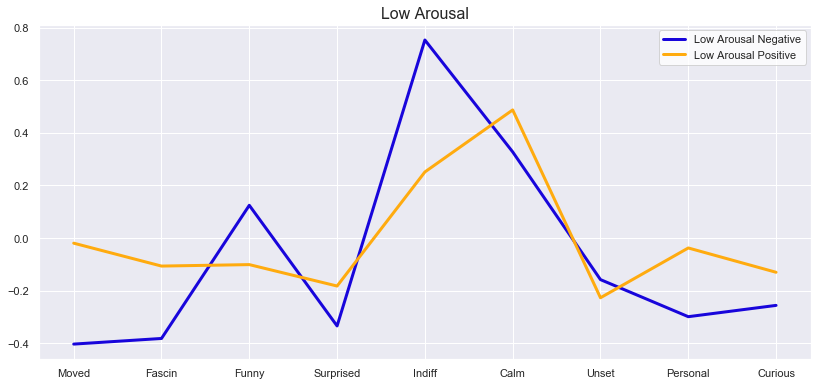

In [50]:
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
plt.title("Low Arousal", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

lA_negative_means = np.mean(lA_negative.iloc[:,4:13])
lA_positive_means = np.mean(lA_positive.iloc[:,4:13])

#ax.plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
#ax.plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)

ax.plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
ax.plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)

plt.legend(facecolor='w')

plt.tight_layout(pad=3.0)

plt.show()

fig.savefig('low-arousal.png')

### Similar to the High Arousal group - in that the categories of interest aren't that differentiated - Calm seems fairily similar between the negative and positive groups. 

### Below, comparison between the two valences:

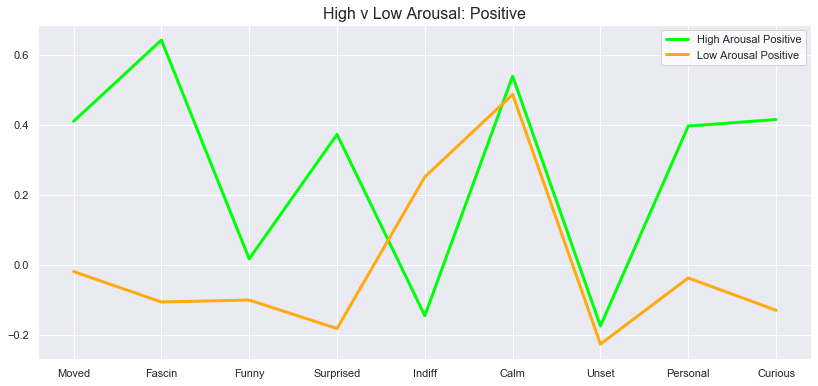

In [51]:
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
plt.title("High v Low Arousal: Positive", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

lA_negative_means = np.mean(lA_negative.iloc[:,4:13])
lA_positive_means = np.mean(lA_positive.iloc[:,4:13])

#ax.plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
ax.plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)

#ax.plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
ax.plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)

plt.legend(facecolor='w')

plt.tight_layout(pad=3.0)

plt.show()

#fig.savefig('low-arousal.png')

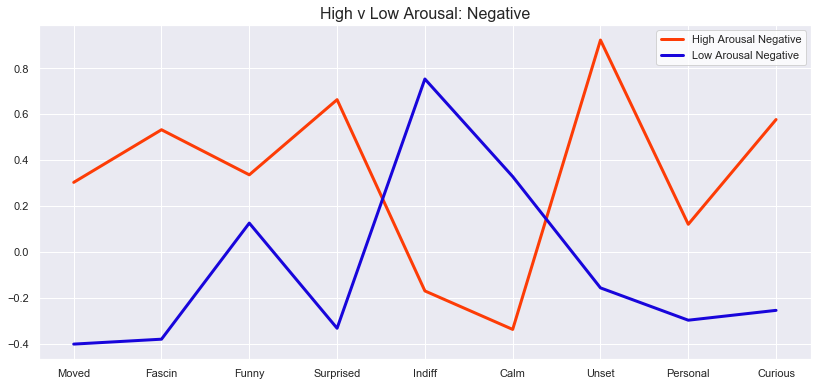

In [52]:
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
plt.title("High v Low Arousal: Negative", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

lA_negative_means = np.mean(lA_negative.iloc[:,4:13])
lA_positive_means = np.mean(lA_positive.iloc[:,4:13])

ax.plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
#ax.plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)

ax.plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
#ax.plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)

plt.legend(facecolor='w')

plt.tight_layout(pad=3.0)

plt.show()

#fig.savefig('low-arousal.png')

### I think this last graph, the High & Low Arousal with Negative valence, looks the most how we want, in that both negative emotions (indifferent and unsettled) are inverses...probably because those are the emotions we split on haha.

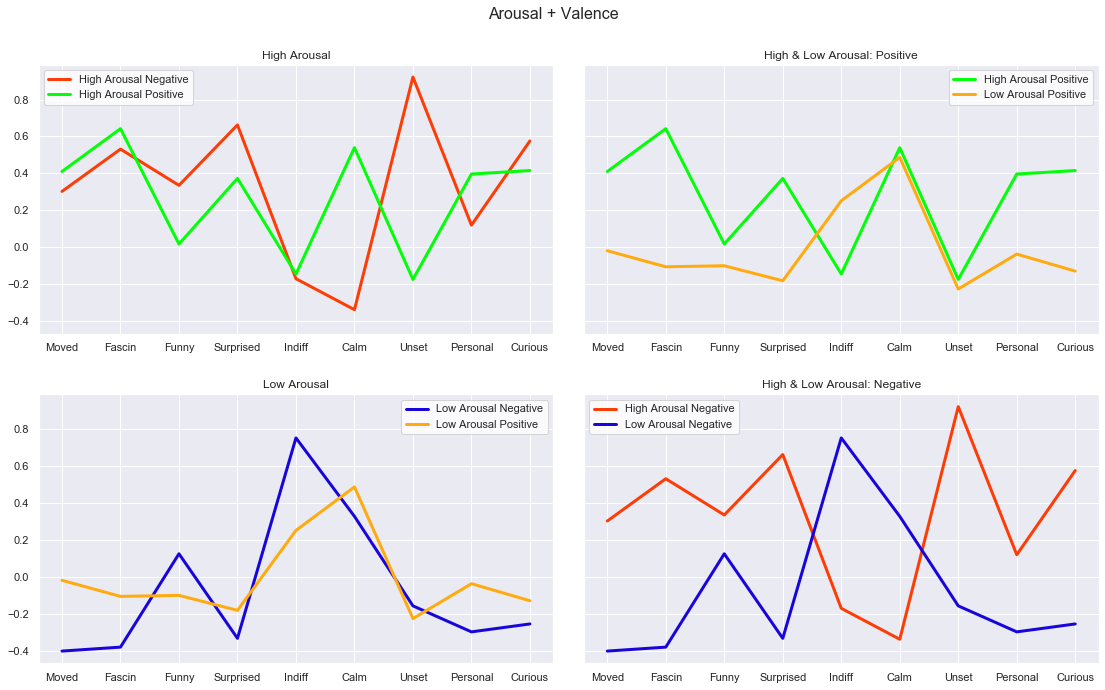

In [53]:
fig, axes= plt.subplots(nrows=2, ncols=2, sharey = True, figsize=(16,10))

emotionLabs = ["filler","Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"]

plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Arousal + Valence", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

lA_negative_means = np.mean(lA_negative.iloc[:,4:13])
lA_positive_means = np.mean(lA_positive.iloc[:,4:13])

#HIGH AROUSAL
axes[0,0].plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
axes[0,0].plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)
axes[0,0].set_title('High Arousal')
axes[0,0].legend(facecolor='w')
axes[0,0].set_xticklabels(emotionLabs)

#LOW AROUSAL
axes[1,0].plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
axes[1,0].plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)
axes[1,0].set_title('Low Arousal')
axes[1,0].legend(facecolor='w')
axes[1,0].set_xticklabels(emotionLabs)

#POSITIVE
axes[0,1].plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)
axes[0,1].plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)
axes[0,1].set_title('High & Low Arousal: Positive')
axes[0,1].legend(facecolor='w')
axes[0,1].set_xticklabels(emotionLabs)

#NEGATIVE
axes[1,1].plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
axes[1,1].plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
axes[1,1].set_title('High & Low Arousal: Negative')
axes[1,1].legend(facecolor='w')
axes[1,1].set_xticklabels(emotionLabs)

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)

plt.show()

#fig.savefig('arousal-valence-original.png')

### Trying to split Arousal on Unsettled-Indifference:

In [73]:
#generating a column of difference scores
highArousal.loc[:,('Diff')] = abs(highArousal.loc[:,('Unsettling')] - highArousal.loc[:,('Indifferent')])
lowArousal.loc[:,('Diff')] = abs(lowArousal.loc[:,('Unsettling')] - lowArousal.loc[:,('Indifferent')])


In [55]:
hA_positive = highArousal.sort_values(by=['Diff']).tail(n=20)
hA_negative = highArousal.sort_values(by=['Diff']).head(n=20)

lA_positive = lowArousal.sort_values(by=['Diff']).tail(n=20)
lA_negative = lowArousal.sort_values(by=['Diff']).head(n=20)

In [56]:
print(hA_negative['Surprised'].sum())
print(hA_positive['Surprised'].sum())
print('')
#highArousal.sort_values(by=['Diff']).iloc[:,0:13]
print(lA_negative['Indifferent'].sum())
print(lA_positive['Indifferent'].sum())
print('')
print(lA_negative['Calm'].sum())
print(lA_positive['Calm'].sum())

7.889917631594604
12.818623226949963

6.387586975094273
13.69362293884127

7.1699803473257715
9.122418290850142


In [57]:
# for both of these, I did Positive - Negative emotion
highArousal.loc[:,('Diff')] = highArousal.loc[:,('Fascinated')] - highArousal.loc[:,('Unsettling')]
    ## I used Fascinated because I didn't want to deal with 4 different emotions....
lowArousal.loc[:,('Diff')] = lowArousal.loc[:,('Calm')] - lowArousal.loc[:,('Indifferent')]

hA_positive = highArousal.sort_values(by=['Diff']).tail(n=20)
hA_negative = highArousal.sort_values(by=['Diff']).head(n=20)

lA_positive = lowArousal.sort_values(by=['Diff']).tail(n=20)
lA_negative = lowArousal.sort_values(by=['Diff']).head(n=20)

In [58]:
print('Fascinated Sums:')
print('High Arousal Positive: ' + str(hA_positive['Fascinated'].sum()))
print('High Arousal Negative: ' + str(hA_negative['Fascinated'].sum()))
print('')
print('Unsettling Sums:')
print('High Arousal Positive: ' + str(hA_positive['Unsettling'].sum()))
print('High Arousal Negative: ' + str(hA_negative['Unsettling'].sum()))
print('')
print('')
#lA_negative = lowArousal.sort_values(by=['Calm']).tail(n=20)
#lA_positive = lowArousal.sort_values(by=['Calm']).head(n=20)
print('')
print('Indifferent Sums:')
print('Low Arousal Positive: ' + str(lA_positive['Indifferent'].sum()))
print('Low Arousal Negative: ' + str(lA_negative['Indifferent'].sum()))
print('')
print('Calm Sums:')
print('Low Arousal Positive: ' + str(lA_positive['Calm'].sum()))
print('Low Arousal Negative: ' + str(lA_negative['Calm'].sum()))

Fascinated Sums:
High Arousal Positive: 14.249655299531703
High Arousal Negative: 9.228482695363459

Unsettling Sums:
High Arousal Positive: -2.2796905819010447
High Arousal Negative: 17.23075873417697



Indifferent Sums:
Low Arousal Positive: 6.753427547089401
Low Arousal Negative: 13.32778236684614

Calm Sums:
Low Arousal Positive: 14.473955121063156
Low Arousal Negative: 1.8184435171127558


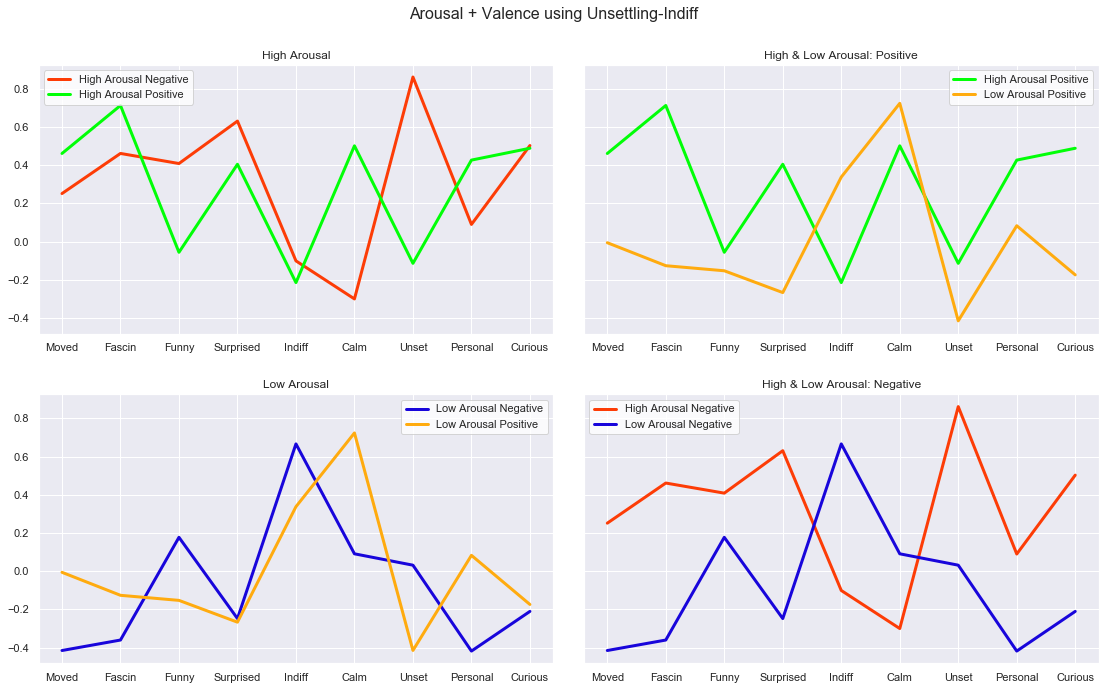

In [59]:
fig, axes= plt.subplots(nrows=2, ncols=2, sharey = True, figsize=(16,10))

emotionLabs = ["filler","Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"]

plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Arousal + Valence using Unsettling-Indiff", size=16)

hA_negative_means = np.mean(hA_negative.iloc[:,4:13])
hA_positive_means = np.mean(hA_positive.iloc[:,4:13])

lA_negative_means = np.mean(lA_negative.iloc[:,4:13])
lA_positive_means = np.mean(lA_positive.iloc[:,4:13])

#HIGH AROUSAL
axes[0,0].plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
axes[0,0].plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)
axes[0,0].set_title('High Arousal')
axes[0,0].legend(facecolor='w')
axes[0,0].set_xticklabels(emotionLabs)

#LOW AROUSAL
axes[1,0].plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
axes[1,0].plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)
axes[1,0].set_title('Low Arousal')
axes[1,0].legend(facecolor='w')
axes[1,0].set_xticklabels(emotionLabs)

#POSITIVE
axes[0,1].plot(ratings, hA_positive_means, label='High Arousal Positive', color='xkcd:bright green', linewidth=3)
axes[0,1].plot(ratings, lA_positive_means, label='Low Arousal Positive', color='xkcd:yellowish orange', linewidth=3)
axes[0,1].set_title('High & Low Arousal: Positive')
axes[0,1].legend(facecolor='w')
axes[0,1].set_xticklabels(emotionLabs)

#NEGATIVE
axes[1,1].plot(ratings, hA_negative_means, label='High Arousal Negative', color='xkcd:red orange', linewidth=3)
axes[1,1].plot(ratings, lA_negative_means, label='Low Arousal Negative', color='xkcd:ultramarine blue', linewidth=3)
axes[1,1].set_title('High & Low Arousal: Negative')
axes[1,1].legend(facecolor='w')
axes[1,1].set_xticklabels(emotionLabs)

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)

plt.show()

#fig.savefig('arousal-valence-v2.png')

## t-SNE Graph

In [60]:
#getting plotting data ready
X_tsned_df = pd.DataFrame(data=X_tsned, columns=["x-coord",'y-coord'])
X_tsned_df['ID'] = names['ID']
X_tsned_df.head(n=5)


## plotting on the t-SNEd graph
X_tsned_hApV= (X_tsned_df.merge(hA_positive)).to_numpy()
X_tsned_hAnV = (X_tsned_df.merge(hA_negative )).to_numpy()

X_tsned_lApV= (X_tsned_df.merge(lA_positive)).to_numpy()
X_tsned_lAnV = (X_tsned_df.merge(lA_negative )).to_numpy()

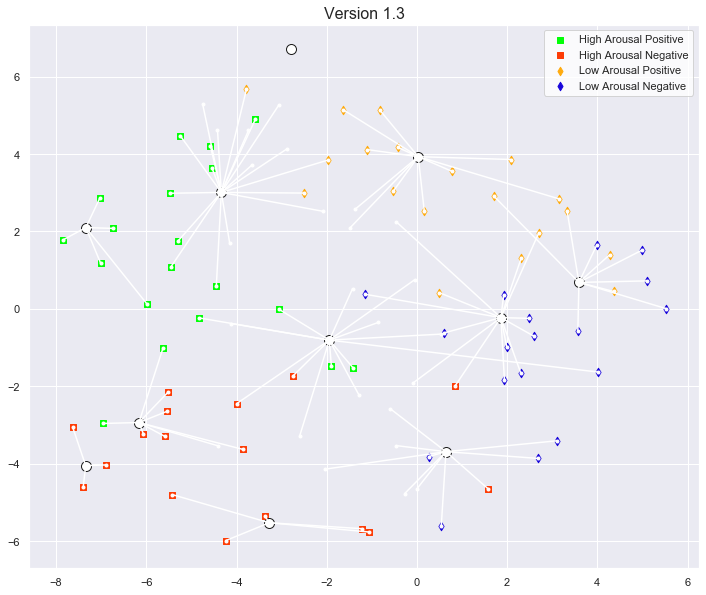

In [61]:
# 1) Valence Score

plt.close('all')
plt.figure(figsize=(12, 10))
plt.clf()

colors = cycle('w')
for k, col in zip(range(n_clusters_2), colors):
    class_members = labels2 == k
    cluster_center = X_tsned[cluster_centers_indices2[k]]
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)
    for x in X_tsned[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

plt.scatter(X_tsned_hApV[:,0],X_tsned_hApV[:,1],c='xkcd:bright green', marker='s', label='High Arousal Positive')
plt.scatter(X_tsned_hAnV[:,0],X_tsned_hAnV[:,1],c='xkcd:red orange', marker='s', label='High Arousal Negative') 

plt.scatter(X_tsned_lApV[:,0],X_tsned_lApV[:,1],c='xkcd:yellowish orange', marker='d', label='Low Arousal Positive')
plt.scatter(X_tsned_lAnV[:,0],X_tsned_lAnV[:,1],c='xkcd:ultramarine blue', marker='d', label='Low Arousal Negative')  
        
plt.title('Version 1.3',size=16)
plt.legend(facecolor='w')

plt.savefig('arousal-valence-tsned-v1.3.png')
plt.show()

# 2) by cluster

In [62]:
#combine clusters 1,2,&9 and 0,3,8,&10

highEmotions = labeledRatings.loc[(labeledRatings.ClusterBefore==0) | (labeledRatings.ClusterBefore==3) | \
                               (labeledRatings.ClusterBefore==8) | (labeledRatings.ClusterBefore==10)]
lowEmotions = labeledRatings.loc[(labeledRatings.ClusterBefore==1) | (labeledRatings.ClusterBefore==2) | \
                               (labeledRatings.ClusterBefore==9)]

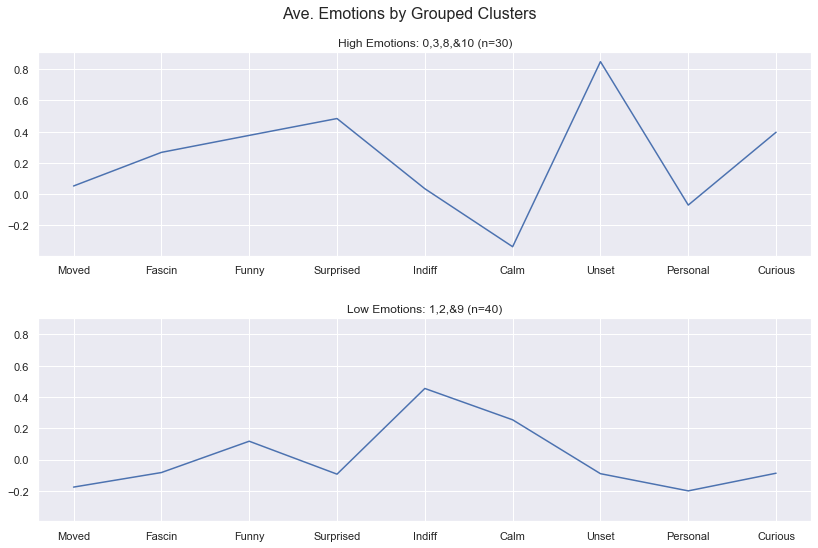

In [63]:
fig, axes= plt.subplots(nrows=2, ncols=1, sharey = True, figsize=(12,8))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Ave. Emotions by Grouped Clusters", size=16)

highEmotionsMeans = np.mean(highEmotions.iloc[:,4:13])
lowEmotionsMeans = np.mean(lowEmotions.iloc[:,4:13])

axes[0].plot(ratings, highEmotionsMeans)
axes[0].set_title('High Emotions: 0,3,8,&10 (n={num})'.format(num=len(highEmotions.index)))

axes[1].plot(ratings, lowEmotionsMeans)
axes[1].set_title('Low Emotions: 1,2,&9 (n={num})'.format(num=len(lowEmotions.index)))

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)

plt.show()

fig.savefig('ave-emotions-grouped-clusters.png')

#### 3) by distinct emotion categories & variability

I wanted to calculate variability of each emotion in order to see which ones had the lowest variability

In [64]:
# create matrix of variance scores for each emotion
#varsPerEachEmotion = np.zeros(9)

#for i in range(0,9):
    #varsPerEachEmotion[i] = np.nanvar(standardRating[:,i+1,:])
    
#emotionNames = ["Moved","Fascinating","Funny","Surprised", "Indifferent","Calm","Unsettling","Personal","Curious"]
#varsPerEachEmotion = pd.DataFrame({'Emotion':emotionNames, 'Variance':varsPerEachEmotion})
#varsPerEachEmotion.sort_values(by=['Variance'])

Going off of this, perhaps we want to use Moved, Unsettling, and Indifferent(as a baseline, since the variability in Indifference is pretty high!)

In [65]:
#create 3 dfs: variability, ave score, and diff. sort on diff

#moved
#moved = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Moved', 'Moved Var']]
#moved['Diff'] = moved['Moved'] - moved['Moved Var']
#moved = moved.sort_values(by=['Diff'], ascending=False)

#Indifference
#indiff = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Indifferent', 'Indiff Var']]
#indiff['Diff'] = indiff['Indifferent'] - indiff['Indiff Var']
#indiff = indiff.sort_values(by=['Indifferent'], ascending=False) ##sorting by rating

#Unsettling
#unsettled = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Unsettling', 'Unset Var']]
#unsettled['Diff'] = unsettled['Unsettling'] - unsettled['Unset Var']
#unsettled = unsettled.sort_values(by=['Unsettling'], ascending=False) ##sorting by rating

In [66]:
#unsettled & Indifferent --> top 20 that have variance less than 2

#unsettledSmall = unsettled[(unsettled['Unset Var']<2)]
#unsettledSmall = unsettledSmall.head(n=20)

#indiffSmall = indiff[(indiff['Indiff Var']<2)]
#indiffSmall = indiffSmall.head(n=20)

#movedSmall = moved.head(n=20)

## Plotting those 3 options on the t-SNE graph

In [67]:
#Valence
#X_tsned_hV = (X_tsned_df.merge(highValence)).to_numpy()
#X_tsned_lV = (X_tsned_df.merge(lowValence)).to_numpy()

#Arousal
#X_tsned_hA = (X_tsned_df.merge(highArousal)).to_numpy()
#X_tsned_lA = (X_tsned_df.merge(lowArousal)).to_numpy()

#Emotion Category
#X_tsned_moved = (X_tsned_df.merge(movedSmall)).to_numpy()
#X_tsned_unsett = (X_tsned_df.merge(unsettledSmall)).to_numpy()
#X_tsned_indiff = (X_tsned_df.merge(indiffSmall)).to_numpy()

In [68]:
# 1) Valence Score

#plt.close('all')
#plt.figure(figsize=(12, 10))
#plt.clf()

#colors = cycle('y')
#for k, col in zip(range(n_clusters_2), colors):
   # class_members = labels2 == k
   # cluster_center = X_tsned[cluster_centers_indices2[k]]
   # plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             #markeredgecolor='k', markersize=10)
    #for x in X_tsned[class_members]:
        #plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

#plt.scatter(X_tsned_hV[:,0],X_tsned_hV[:,1],c='xkcd:red orange', marker='s')
#plt.scatter(X_tsned_lV[:,0],X_tsned_lV[:,1],c='xkcd:bluish purple', marker='s')  
        
#plt.title('Version 1: High (red) versus Low (blue) Valence',size=16)

#plt.savefig('valence-tsned.png')
#plt.show()

In [69]:
#2) Arousal/Grouped Clusters

#plt.close('all')
#plt.figure(figsize=(12, 10))
#plt.clf()

#colors = cycle('y')
#for k, col in zip(range(n_clusters_2), colors):
    #class_members = labels2 == k
    #cluster_center = X_tsned[cluster_centers_indices2[k]]
    #plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             #markeredgecolor='k', markersize=10)
    #for x in X_tsned[class_members]:
        #plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

#plt.scatter(X_tsned_hA[:,0],X_tsned_hA[:,1],c='xkcd:bright purple', marker='s')
#plt.scatter(X_tsned_lA[:,0],X_tsned_lA[:,1],c='xkcd:kelly green', marker='s')  
        
#plt.title('Version 2: High (purple) versus Low (green) Arousal',size=16)
#plt.savefig('arousal-tsned.png')
#plt.show()

In [70]:
#3)

#plt.close('all')
#plt.figure(figsize=(12, 10))
#plt.clf()

#colors = cycle('y')
#for k, col in zip(range(n_clusters_2), colors):
    #class_members = labels2 == k
    #cluster_center = X_tsned[cluster_centers_indices2[k]]
    #plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             #markeredgecolor='k', markersize=10)
    #for x in X_tsned[class_members]:
        #plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

#plt.scatter(X_tsned_moved[:,0],X_tsned_moved[:,1],c='xkcd:cyan', marker='s')
#plt.scatter(X_tsned_unsett[:,0],X_tsned_unsett[:,1],c='xkcd:neon green', marker='s')
#plt.scatter(X_tsned_indiff[:,0],X_tsned_indiff[:,1],c='xkcd:hot pink', marker='s') 
        
#plt.title('Version 3: Moved (cyan) vs Unsettled (green) vs Indifferent (pink)',size=16)
#plt.savefig('emotion-category-tsned.png')
#plt.show()

In [71]:
#['Title','Artist','Gallery','ID']
#paintingList = pd.concat([movedSmall, unsettledSmall, indiffSmall], sort=False)
#paintingList.to_excel('paintingList.xlsx')

In [72]:
#histogram of all ratings? --> they all looked relatively the same :/
#fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

#emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
#fig.suptitle("Num Ratings per Emotion Standardized", size=16)

#dim=331
#for i in range(1,10):
    #xmin, xmax = min(standardRating[:,i,0]), max(standardRating[:,i,0])
    #plt.subplot(dim+(i-1), \
                      #xlabel="Score", ylabel="Num Times Used",\
                   # xticks=np.arange(-3, 4, 1)
                     #)
    #plt.hist(standardRating[:,i,:], range=[-3.0, 4.0], align='left') #bins=7
    #plt.title(emotionList[i-1])
                  
#plt.tight_layout(pad=3.0)
#fig.subplots_adjust(top=0.88)